<a href="https://colab.research.google.com/github/zeinabmazraani/nnUNet_MSSEG_and_Testing/blob/main/nnunetMSSEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install nnunetv2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.5 MB/s eta 0:00:00
  Created wheel for nnunetv2: filename=nnunetv2-2.6.2

In [ ]:
import os
os.environ["nnUNet_raw"] = "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/content/drive/MyDrive/nnUNetZeinab/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/content/drive/MyDrive/nnUNetZeinab/nnUNet_results"



Now i need to convert to the expected hierarchy known by nnUnet:
nnUNet_raw/


*   Dataset501_MSSEG/
1.   imagesTr/
2.   labelsTr/

1.   imagesTs/
2.   dataset.json





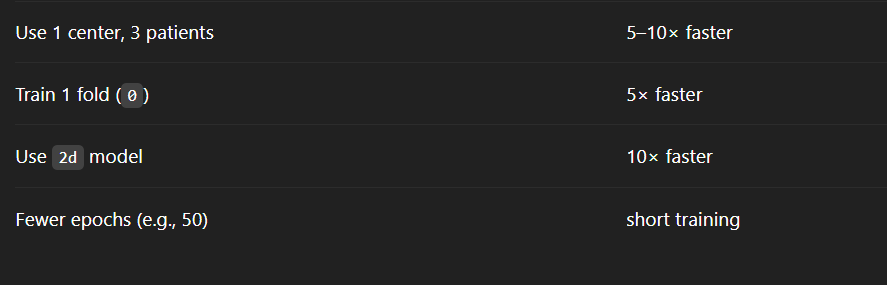![image.png]()Use only FLAIR and T1, since that’s the most informative for MS lesions.


ONLY RUN THE BELOW ONCE

In [ ]:
import os, shutil, glob

# Paths
DATASET_DIR = "/content/drive/MyDrive/MSSEG dataset/Training"
base = "/content/drive/MyDrive/nnUNetZeinab"

# Create the target nnUNet folders if they don’t exist
os.makedirs(f"{base}/nnUNet_raw/Dataset501_MSSEG/imagesTr", exist_ok=True)
os.makedirs(f"{base}/nnUNet_raw/Dataset501_MSSEG/labelsTr", exist_ok=True)

dst_root = f"{base}/nnUNet_raw/Dataset501_MSSEG"

# Process only the available centers (you can add others later)
centers = ['Center_01']

for center in centers:
    center_path = os.path.join(DATASET_DIR, center)
    for patient in sorted(os.listdir(center_path)):
        p_path = os.path.join(center_path, patient)

        flair_files = glob.glob(os.path.join(p_path, "Preprocessed_Data", "*FLAIR_preprocessed.nii*"))
        t1_files    = glob.glob(os.path.join(p_path, "Preprocessed_Data", "*T1_preprocessed.nii*"))
        seg_files   = glob.glob(os.path.join(p_path, "Masks", "Consensus.nii*"))

        if not flair_files or not t1_files or not seg_files:
            print(f"Missing file(s) for {patient}")
            print("  FLAIR:", flair_files)
            print("  T1:", t1_files)
            print("  SEG:", seg_files)
            continue

        flair = flair_files[0]
        t1 = t1_files[0]
        seg = seg_files[0]

        pid = patient
        shutil.copy(flair, f"{dst_root}/imagesTr/{pid}_0000.nii.gz")  # FLAIR
        shutil.copy(t1,    f"{dst_root}/imagesTr/{pid}_0001.nii.gz")  # T1
        shutil.copy(seg,   f"{dst_root}/labelsTr/{pid}.nii.gz")       # Consensus

print("✅ Copied FLAIR + T1 + labels successfully!")


Missing file(s) for .DS_Store
  FLAIR: []
  T1: []
  SEG: []
✅ Copied FLAIR + T1 + labels successfully!


In [ ]:
import json, glob

dst_root = "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG"

dataset_json = {
    "channel_names": {
        "0": "FLAIR",
        "1": "T1"
    },
    "labels": {
        "background": 0,
        "lesion": 1
    },
    "numTraining": len(glob.glob(f"{dst_root}/labelsTr/*.nii.gz")),
    "file_ending": ".nii.gz",
    "name": "MSSEG",
    "description": "MS lesion segmentation challenge",
    "tensorImageSize": "4D",
    "reference": "MICCAI MSSEG 2016",
    "licence": "CC BY-NC-SA 4.0",
    "release": "1.0"
}

with open(f"{dst_root}/dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

print("✅ Rewritten with correct label format.")


✅ Rewritten with correct label format.


In [ ]:
!cat "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/dataset.json"


{
    "name": "MSSEG",
    "description": "MS lesion segmentation challenge",
    "tensorImageSize": "4D",
    "reference": "MICCAI MSSEG 2016",
    "licence": "CC BY-NC-SA 4.0",
    "release": "1.0",
    "channel_names": {
        "0": "FLAIR",
        "1": "T1"
    },
    "labels": {
        "0": "background",
        "1": "lesion"
    },
    "numTraining": 5,
    "file_ending": ".nii.gz"
}

In [ ]:
#cleaning cached files
!rm -rf "/content/drive/MyDrive/nnUNetZeinab/nnUNet_preprocessed/Dataset501_MSSEG"


In [ ]:
!ls "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG"
!cat "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/dataset.json"


dataset.json  imagesTr	labelsTr
{
    "channel_names": {
        "0": "FLAIR",
        "1": "T1"
    },
    "labels": {
        "background": 0,
        "lesion": 1
    },
    "numTraining": 5,
    "file_ending": ".nii.gz",
    "name": "MSSEG",
    "description": "MS lesion segmentation challenge",
    "tensorImageSize": "4D",
    "reference": "MICCAI MSSEG 2016",
    "licence": "CC BY-NC-SA 4.0",
    "release": "1.0"
}

In [ ]:
!rm -rf "/content/drive/MyDrive/nnUNetZeinab/nnUNet_preprocessed/Dataset501_MSSEG"


In [ ]:
# Keep only this one
!ls "/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/dataset.json"

# Delete the extra one inside /nnUNet (old)
!rm "/content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset501_MSSEG/dataset.json"


/content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/dataset.json


In [ ]:
# preprocess quickly
!nnUNetv2_plan_and_preprocess -d 501 -np 2


# fast 2D training
import os
os.environ["nnUNet_max_num_epochs"] = "50"

!nnUNetv2_train 501 2d 0



Fingerprint extraction...
Dataset501_MSSEG
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 5/5 [00:42<00:00,  8.45s/it]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Attempting to find 3d_lowres config. 
Current spacing: [1.0999999  0.51298828 0.51298828]. 
Current patch size: (np.int64(64), np.int64(160), np.int64(192)). 
Current median shape: [120.         272.81553398 320.38834951]
Attempting to find 3d_lowres config. 
Current spacing: [1.0999999  0.52837793 0.52837793]. 
Current patch size: (np.int64(64), np.int64(160), np.int64(192)). 
Current median shape: [120.         264.86945047 311.05665001]
Attempting to find 3d_lowres config. 
Current spacing: [1.0999999  0.54422927 0.54422927

for next time

In [ ]:
!nnUNetv2_train 501 2d 0 --c




############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-11-04 07:50:43.435359: Using torch.compile...
2025-11-04 07:50:57.319427: do_dummy_2d_data_aug: False
2025-11-04 07:50:57.325070: Using splits from existing split file: /content/drive/MyDrive/nnUNetZeinab/nnUNet_preprocessed/Dataset501_MSSEG/splits_final.json
2025-11-04 07:50:57.626919: The

NOW TO VISUALIZE RESULTS

In [ ]:
!ls "/content/drive/MyDrive/nnUNetZeinab/nnUNet_results/Dataset501_MSSEG/nnUNetTrainer__nnUNetPlans__2d/fold_0"


checkpoint_best.pth  training_log_2025_11_2_01_24_41.txt
debug.json	     training_log_2025_11_4_07_50_41.txt
progress.png


In [ ]:
!nnUNetv2_predict \
 -i /content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/imagesTr \
 -o /content/drive/MyDrive/nnUNetZeinab/preds_10epoch \
 -d 501 -c 2d -f 0 \
 -chk checkpoint_best.pth



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 5 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 5 cases that I would like to predict

Predicting Patient_01:
perform_everything_on_device: True
100% 126/126 [00:06<00:00, 18.98it/s]
sending off prediction to background worker for resampling and export
done with Patient_01

Predicting Patient_02:
perform_everything_on_device: True
100% 130/130 [00:10<00:00, 12.92it/s]
sending off prediction to background worker for resampling and export
done with Patient_02

Predicting Patient_03:
perform_everything_on_device: True


Showing case 4: Patient_05
FLAIR: /content/drive/MyDrive/nnUNetZeinab/nnUNet_raw/Dataset501_MSSEG/imagesTr/Patient_05_0000.nii.gz
Prediction: /content/drive/MyDrive/nnUNetZeinab/preds_10epoch/Patient_05.nii.gz


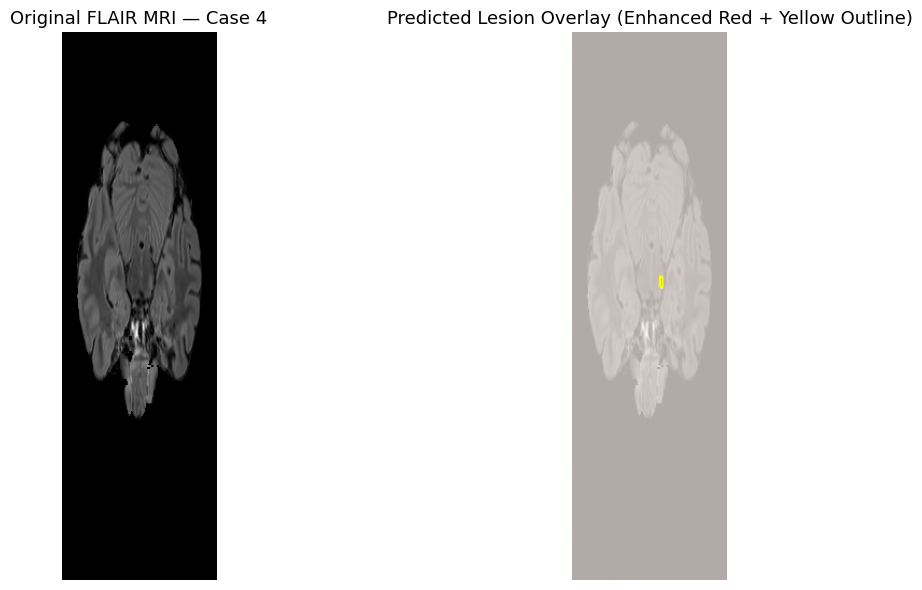

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
base = "/content/drive/MyDrive/nnUNetZeinab"
raw_dir = f"{base}/nnUNet_raw/Dataset501_MSSEG/imagesTr"
pred_dir = f"{base}/preds_10epoch"

# 🔢 Change this index ONLY to switch patients (0, 1, 2, 3, ...)
patient_index = 4 # <-- change this number to view another patient

# Pick the case automatically
cases = sorted([f for f in os.listdir(raw_dir) if f.endswith("_0000.nii.gz")])
case_name = cases[patient_index].replace("_0000.nii.gz", "")

flair_path = os.path.join(raw_dir, f"{case_name}_0000.nii.gz")
pred_path = os.path.join(pred_dir, f"{case_name}.nii.gz")

print(f"Showing case {patient_index}: {case_name}")
print("FLAIR:", flair_path)
print("Prediction:", pred_path)

# Load the NIfTI images
flair_img = nib.load(flair_path).get_fdata()
pred_img = nib.load(pred_path).get_fdata()

# Choose the middle slice (adjust if you want)
mid_slice = flair_img.shape[2] // 2
flair_slice = flair_img[:, :, mid_slice]
pred_slice = pred_img[:, :, mid_slice]

# --- Visualization ---
plt.figure(figsize=(14, 6))

# Original MRI
plt.subplot(1, 2, 1)
plt.imshow(flair_slice.T, cmap='gray', origin='lower')
plt.title(f"Original FLAIR MRI — Case {patient_index}", fontsize=13)
plt.axis('off')

# Prediction overlay
plt.subplot(1, 2, 2)
plt.imshow(flair_slice.T, cmap='gray', origin='lower')
pred_display = np.clip(pred_slice.T * 3, 0, 1)  # make lesions pop
plt.imshow(pred_display, cmap='Reds', alpha=0.7, origin='lower')
plt.contour(pred_slice.T, colors='yellow', linewidths=0.7, alpha=0.9)

plt.title("Predicted Lesion Overlay (Enhanced Red + Yellow Outline)", fontsize=13)
plt.axis('off')

plt.tight_layout()
plt.show()


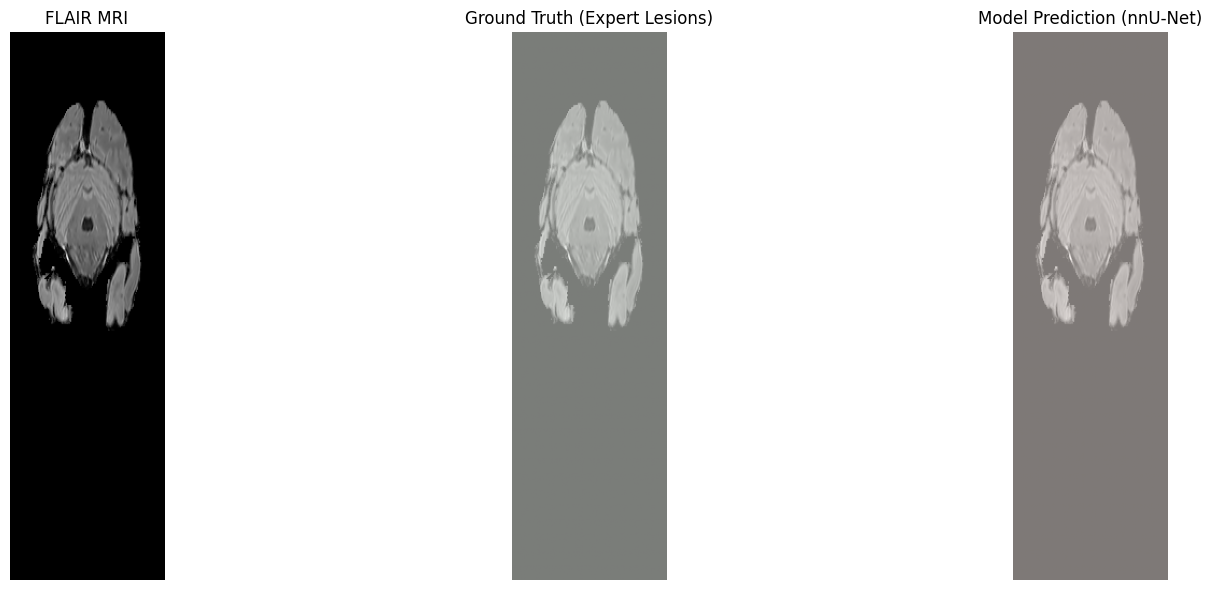

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

base = "/content/drive/MyDrive/nnUNetZeinab"
raw_dir = f"{base}/nnUNet_raw/Dataset501_MSSEG/imagesTr"
label_dir = f"{base}/nnUNet_raw/Dataset501_MSSEG/labelsTr"
pred_dir = f"{base}/preds_10epoch"

case_name = "Patient_04"  # change as needed

flair = nib.load(f"{raw_dir}/{case_name}_0000.nii.gz").get_fdata()
pred  = nib.load(f"{pred_dir}/{case_name}.nii.gz").get_fdata()
gt    = nib.load(f"{label_dir}/{case_name}.nii.gz").get_fdata()

mid = flair.shape[2] // 2

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(flair[:, :, mid].T, cmap='gray', origin='lower')
plt.title("FLAIR MRI")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(flair[:, :, mid].T, cmap='gray', origin='lower')
plt.imshow(gt[:, :, mid].T, cmap='Greens', alpha=0.5, origin='lower')
plt.title("Ground Truth (Expert Lesions)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(flair[:, :, mid].T, cmap='gray', origin='lower')
plt.imshow(pred[:, :, mid].T, cmap='Reds', alpha=0.5, origin='lower')
plt.title("Model Prediction (nnU-Net)")
plt.axis('off')

plt.tight_layout()
plt.show()


NEW BLOCKS FOR TESTING ON NEW AUBMC DATA

In [ ]:
import os, json, shutil

json_path = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January/dataset.json"
src_root  = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"
dst_root  = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"

os.makedirs(f"{dst_root}/imagesTs", exist_ok=True)
os.makedirs(f"{dst_root}/labelsTs", exist_ok=True)

with open(json_path, "r") as f:
    dataset = json.load(f)

for entry in dataset["training"]:
    pid = entry["id"]
    imgs = entry["image"]   # [TP1, TP2]
    lbl  = entry["label"]

    # --- COPY TP1 as channel 0 ---
    src_tp1 = os.path.join(src_root, imgs[0].replace("./", ""))
    dst_tp1 = os.path.join(dst_root, "imagesTs", f"{pid}_0000.nii.gz")
    shutil.copy(src_tp1, dst_tp1)

    # --- COPY TP2 as channel 1 ---
    src_tp2 = os.path.join(src_root, imgs[1].replace("./", ""))
    dst_tp2 = os.path.join(dst_root, "imagesTs", f"{pid}_0001.nii.gz")
    shutil.copy(src_tp2, dst_tp2)

    # --- COPY ground truth ---
    src_lbl = os.path.join(src_root, lbl.replace("./", ""))
    dst_lbl = os.path.join(dst_root, "labelsTs", f"{pid}.nii.gz")
    shutil.copy(src_lbl, dst_lbl)

print("✅ DONE: Correct nnU-Net format created!")


✅ DONE: Correct nnU-Net format created!


In [ ]:
!mkdir -p /content/test_case
!cp /content/drive/MyDrive/nnUNetZeinab/reviewed_data/imagesTs/00713519_*.nii.gz /content/test_case/


In [ ]:
!nnUNetv2_predict \
 -i /content/drive/MyDrive/nnUNetZeinab/reviewed_data/imagesTs \
 -o /content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds \
 -d 501 -c 2d -f 0 \
 -chk checkpoint_best.pth \
 -npp 1 \
 -nps 1



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 12 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 12 cases that I would like to predict

Predicting 00713519:
perform_everything_on_device: True
100% 1956/1956 [01:19<00:00, 24.56it/s]
sending off prediction to background worker for resampling and export
done with 00713519

Predicting 00960975:
perform_everything_on_device: True
100% 1956/1956 [01:17<00:00, 25.17it/s]
sending off prediction to background worker for resampling and export
done with 00960975

Predicting 00981157:
perform_everything_on_device: True
100%

In [ ]:
import os

base = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"
cases = sorted(os.listdir(base))

for c in cases:
    folder = os.path.join(base, c)
    if os.path.isdir(folder):
        print(f"\n=== {c} ===")
        for f in os.listdir(folder):
            print("   ", f)



=== 00408990 ===
    FLAIR_1.nii.gz
    sub_2_1.nii.gz
    FLAIR_2.nii.gz
    sub_1_2.nii.gz

=== 00713519 ===
    FLAIR_2_to_FLAIR_1.mat
    Segmentation-label.nii.gz
    00713519_20190830.nii.gz
    00713519_20190830_to_FLAIR_1.nii.gz
    00713519_20181002.nii.gz

=== 00960975 ===
    Segmentation-label.nii.gz
    FLAIR_2_to_FLAIR_1.mat
    00960975_20180222.nii.gz
    00960975_20190822_to_FLAIR_1.nii.gz
    00960975_20190822.nii.gz

=== 00981157 ===
    Segmentation-label.nii.gz
    00981157_20170110.nii.gz
    00981157_20170210_to_FLAIR_1.nii.gz
    FLAIR_2_to_FLAIR_1.mat
    00981157_20170210.nii.gz

=== 01092669 ===
    01092669_20171206.nii.gz
    01092669_20190309.nii.gz
    01092669_20190309_to_FLAIR_1.nii.gz
    FLAIR_2_to_FLAIR_1.mat
    Segmentation-label.nii.gz

=== 01386182 ===
    FLAIR_2_to_FLAIR_1.mat
    Segmentation-label.nii.gz
    01386182_20180213.nii.gz
    01386182_20190115.nii.gz
    01386182_20190115_to_FLAIR_1.nii.gz

=== 01406050 ===
    01406050_20180430.n

This is the best output yet, but im using the middle slice (since MRI is a 3D volume) and thats why the images look inconsistent and sometimes ground truth shows no lesions at all. so i will try this, and i will also try to plot on the slice witht he most lesions on the ground truth


===== Plotting Case 00713519 =====


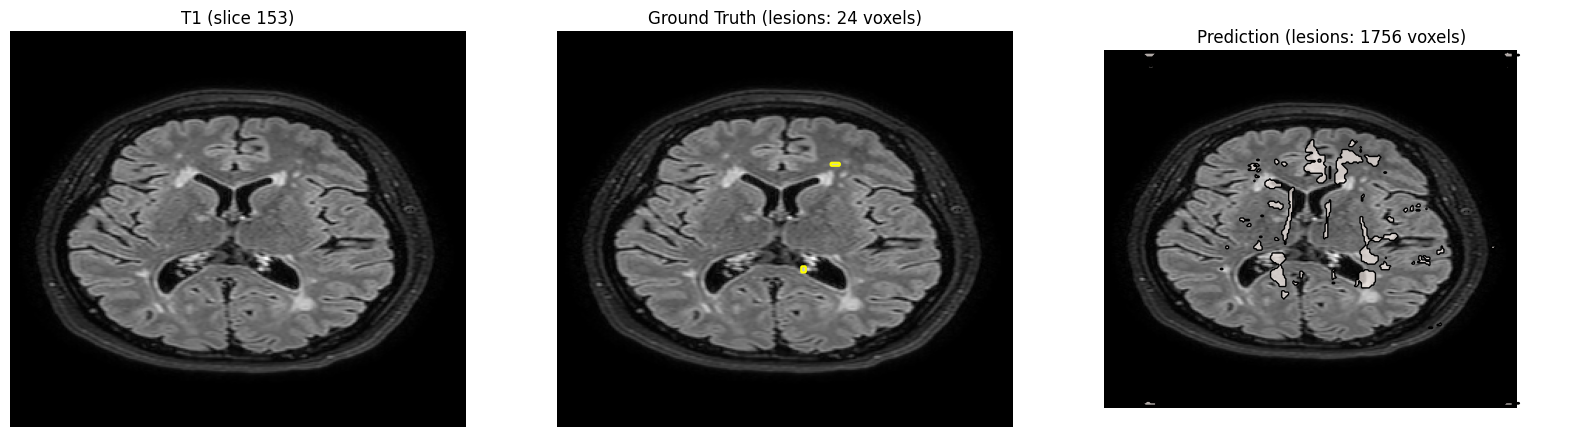


===== Plotting Case 00960975 =====


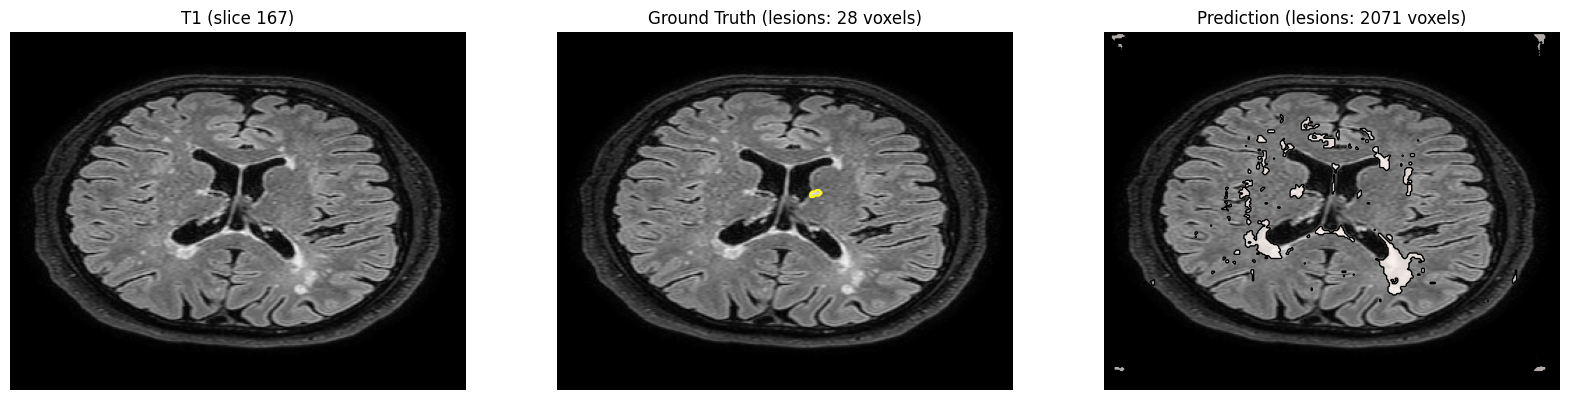


===== Plotting Case 00981157 =====


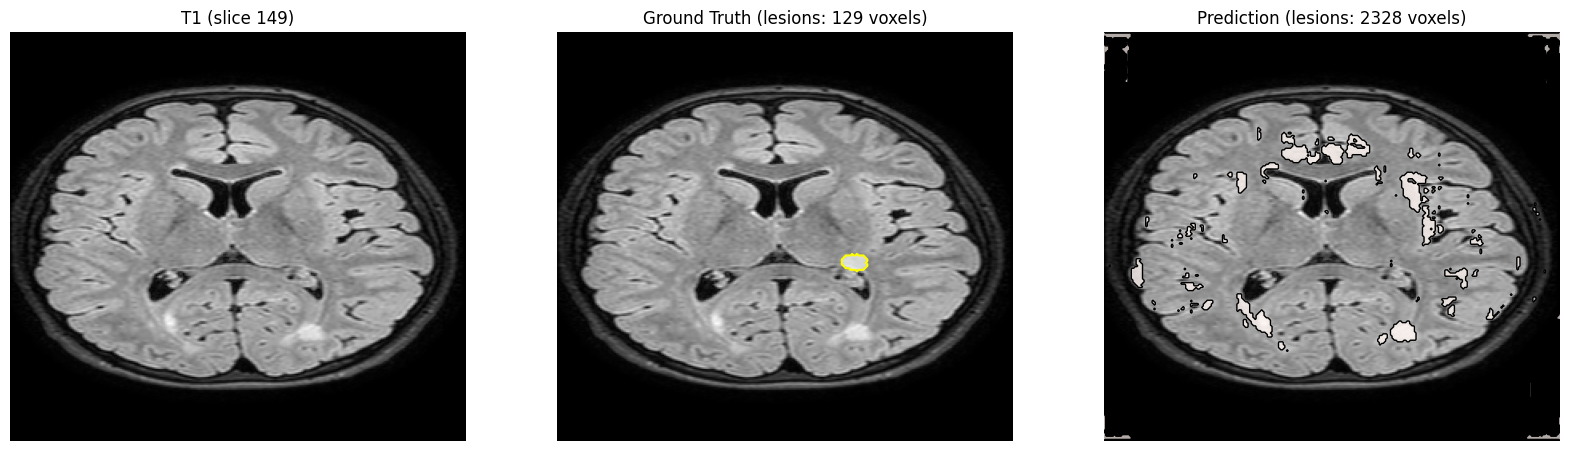


===== Plotting Case 01092669 =====


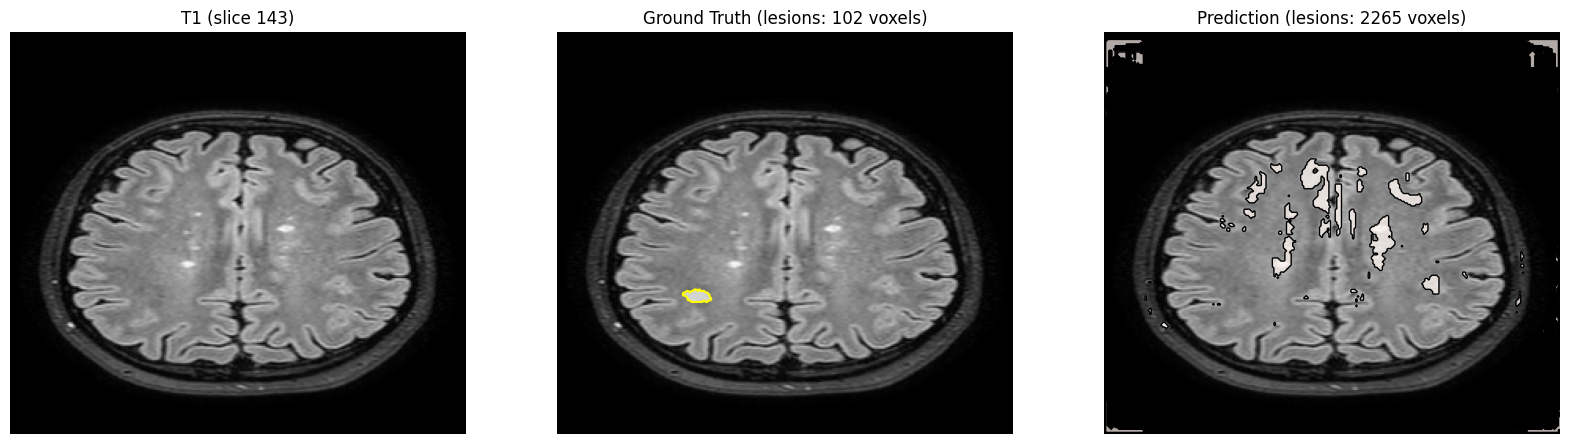


===== Plotting Case 01386182 =====


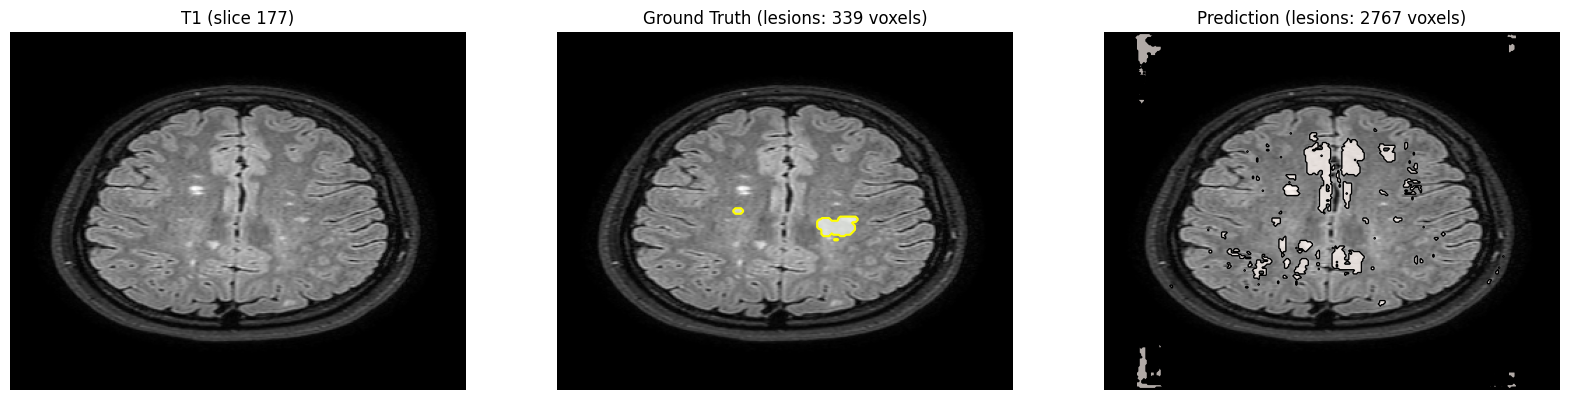


===== Plotting Case 01406050 =====


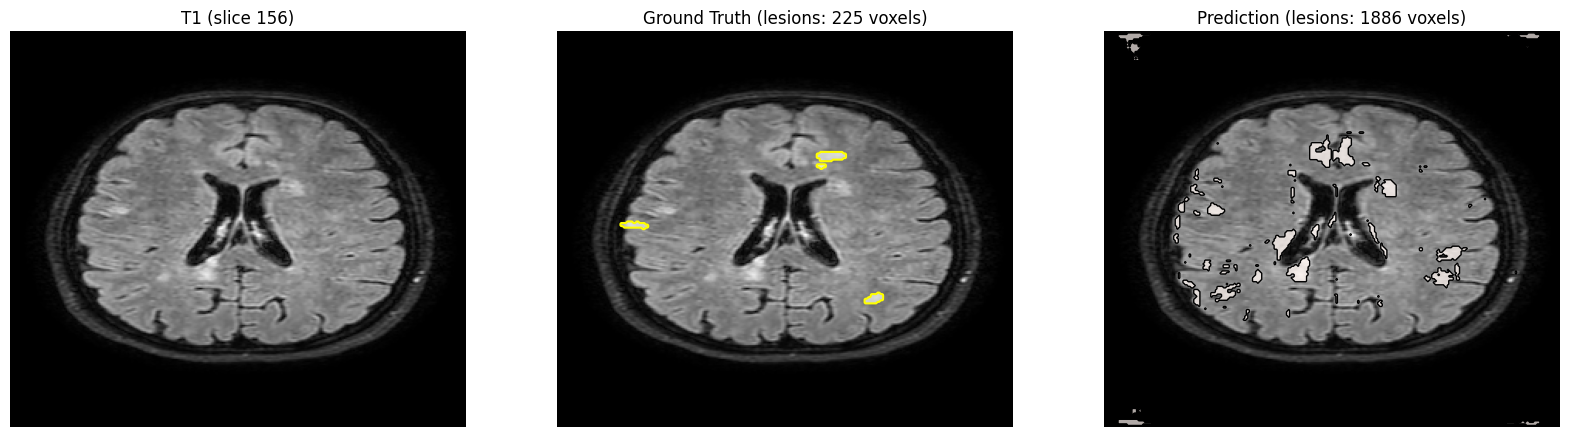


===== Plotting Case 01563167 =====


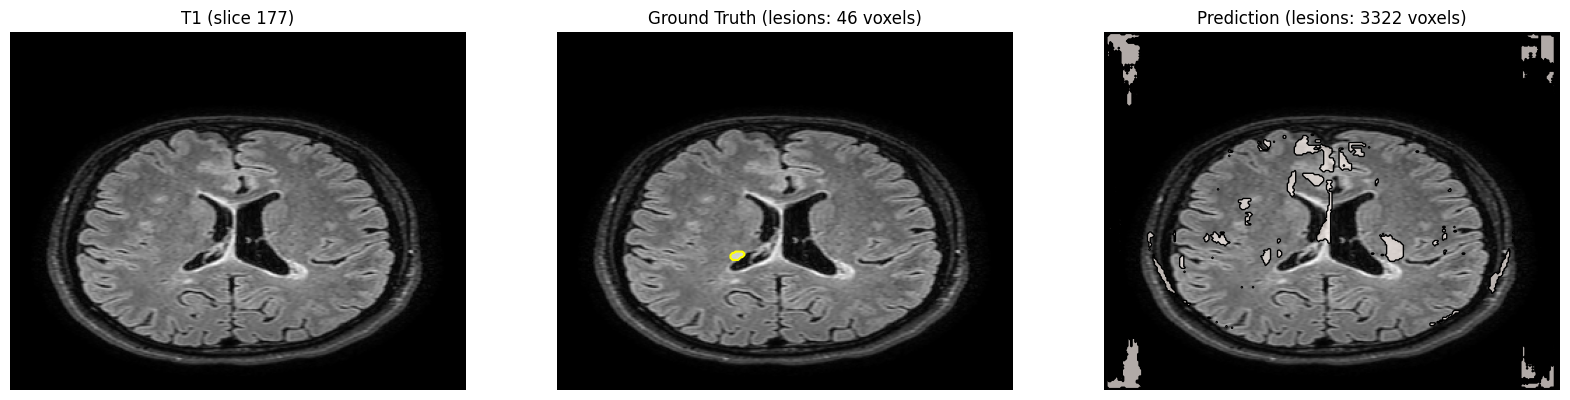


===== Plotting Case 01581148_2 =====


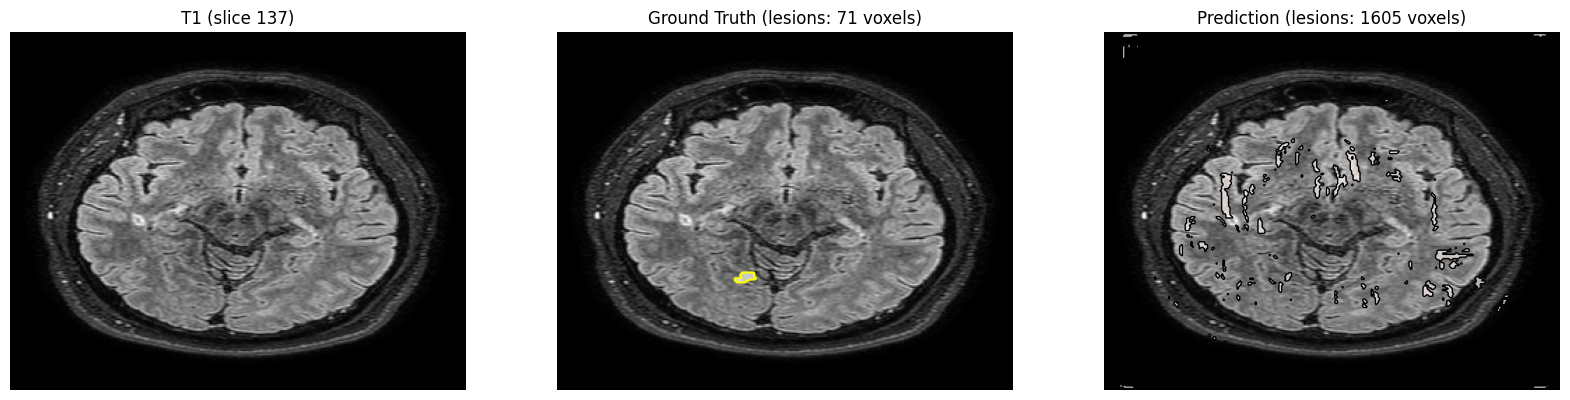


===== Plotting Case 01581148_4 =====


FileNotFoundError: No T1 file for 01581148_4

In [ ]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

cases_base = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"
pred_base  = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds"


def load_files(case_id):
    folder = os.path.join(cases_base, case_id)

    # ----- Ground Truth -----
    gt_file = None
    for f in os.listdir(folder):
        if f.startswith("Segmentation-label") and f.endswith(".nii.gz"):
            gt_file = os.path.join(folder, f)
            break
    if gt_file is None:
        raise FileNotFoundError("GT file missing for " + case_id)

    # ----- Timepoint 2 (T2) -----
    t2_file = None
    for f in os.listdir(folder):
        if f.endswith("_to_FLAIR_1.nii.gz"):
            t2_file = os.path.join(folder, f)
            break
    if t2_file is None:
        raise FileNotFoundError("No T2 file for " + case_id)

    # ----- Timepoint 1 (T1) -----
    t1_file = None
    nii_files = [f for f in os.listdir(folder) if f.endswith(".nii.gz")]
    for f in nii_files:
        if f.startswith(case_id) and ("to_FLAIR" not in f) and ("Segmentation" not in f):
            t1_file = os.path.join(folder, f)
            break
    if t1_file is None:
        raise FileNotFoundError("No T1 file for " + case_id)

    # ----- Prediction file -----
    pred_file = None
    for f in os.listdir(pred_base):
        if f.startswith(case_id):
            pred_file = os.path.join(pred_base, f)
            break
    if pred_file is None:
        raise FileNotFoundError("No prediction found for " + case_id)

    return t1_file, t2_file, gt_file, pred_file



def plot_case(case_id):
    print(f"\n===== Plotting Case {case_id} =====")

    t1_file, t2_file, gt_file, pred_file = load_files(case_id)

    # Load volumes
    t1   = nib.load(t1_file).get_fdata()
    gt   = nib.load(gt_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    # Resample GT to T1 resolution
    scale = np.array(t1.shape) / np.array(gt.shape)
    gt_resampled = zoom(gt, scale, order=0)

    # Binary masks
    gt_bin   = (gt_resampled > 0).astype(np.uint8)
    pred_bin = (pred > 0).astype(np.uint8)

    # 🔥 choose a slice with lesions if possible
    lesion_slices = np.where(gt_bin.sum(axis=(0, 1)) > 0)[0]
    if len(lesion_slices) > 0:
        mid = lesion_slices[len(lesion_slices) // 2]
    else:
        mid = t1.shape[2] // 2

    # Extract slices
    t1_slice   = t1[:, :, mid]
    gt_slice   = gt_bin[:, :, mid]
    pred_slice = pred_bin[:, :, mid]

    plt.figure(figsize=(20, 6))

    # =====================================
    # 1) T1 SLICE
    # =====================================
    plt.subplot(1, 3, 1)
    plt.imshow(t1_slice.T, cmap="gray", origin="lower")
    plt.title(f"T1 (slice {mid})")
    plt.axis("off")

    # =====================================
    # 2) GROUND TRUTH WITH OUTLINE
    # =====================================
    plt.subplot(1, 3, 2)
    plt.imshow(t1_slice.T, cmap="gray", origin="lower")

    # bright green mask
    gt_mask = np.ma.masked_where(gt_slice.T == 0, gt_slice.T)
    plt.imshow(gt_mask, cmap='Greens', alpha=0.7, origin="lower")

    # yellow contour outline
    plt.contour(gt_slice.T, levels=[0.5], colors='yellow', linewidths=1.5)

    plt.title(f"Ground Truth (lesions: {gt_slice.sum():.0f} voxels)")
    plt.axis("off")

    # =====================================
    # 3) PREDICTION WITH OUTLINE
    # =====================================
    plt.subplot(1, 3, 3)
    plt.imshow(t1_slice.T, cmap="gray", origin="lower")

    # bright red
    pred_mask = np.ma.masked_where(pred_slice.T == 0, pred_slice.T)
    plt.imshow(pred_mask, cmap='Reds', alpha=0.7, origin="lower")

    # black outline for clarity
    plt.contour(pred_slice.T, levels=[0.5], colors='black', linewidths=1)

    plt.title(f"Prediction (lesions: {pred_slice.sum():.0f} voxels)")
    plt.axis("off")

    plt.show()



valid_cases = [
    "00713519","00960975","00981157","01092669","01386182",
    "01406050","01563167","01581148_2","01581148_4",
    "01668999","01722254","01888003",
]

for case_id in valid_cases:
    plot_case(case_id)


Try here to see if case 01406050_1 works

In [ ]:
import os

pred_path = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds"
print("Files in preds:", os.listdir(pred_path))


Files in preds: ['predict_from_raw_data_args.json', 'dataset.json', 'plans.json', '00713519.nii.gz', '00960975.nii.gz', '00981157.nii.gz', '01092669.nii.gz', '01386182.nii.gz', '01406050_1.nii.gz', '01563167.nii.gz', '01581148_2.nii.gz', '01581148_4.nii.gz', '01668999.nii.gz', '01722254.nii.gz', '01888003.nii.gz']


In [ ]:
import nibabel as nib
import numpy as np

case_id = "01406050"  # change if needed

base = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"
pred_base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds"

t1 = nib.load(f"{base}/{case_id}/{case_id}_20180430.nii.gz").get_fdata()
t2 = nib.load(f"{base}/{case_id}/{case_id}_20180430_to_FLAIR_1.nii.gz").get_fdata()
gt = nib.load(f"{base}/{case_id}/Segmentation-label.nii.gz").get_fdata()
pred = nib.load(f"{pred_base}/{case_id}_1.nii.gz").get_fdata()

print("T1:", t1.shape)
print("T2:", t2.shape)
print("GT:", gt.shape)
print("PRED:", pred.shape)



T1: (295, 256, 256)
T2: (144, 512, 512)
GT: (144, 512, 512)
PRED: (295, 256, 256)


In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import os

case_id = "01406050"

base = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"
pred_base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds"

t1 = nib.load(f"{base}/{case_id}/{case_id}_20180430.nii.gz").get_fdata()
t2 = nib.load(f"{base}/{case_id}/{case_id}_20180430_to_FLAIR_1.nii.gz").get_fdata()
gt = nib.load(f"{base}/{case_id}/Segmentation-label.nii.gz").get_fdata()
pred = nib.load(f"{pred_base}/{case_id}_1.nii.gz").get_fdata()


In [ ]:
# Compute scaling factor
scale = np.array(t1.shape) / np.array(gt.shape)

# Resample GT to T1 resolution
gt_resampled = zoom(gt, scale, order=0)


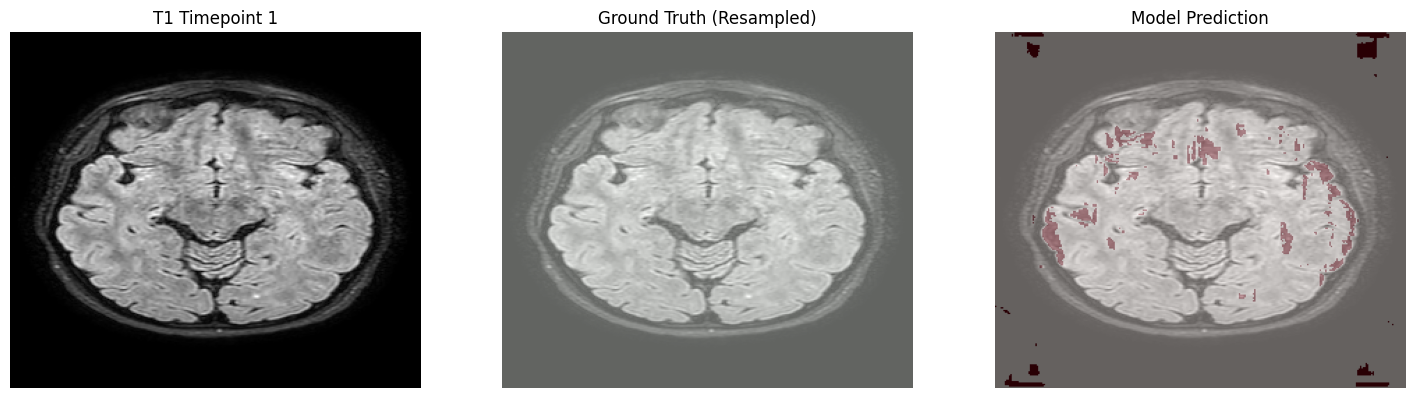

In [ ]:
mid = t1.shape[2] //2

t1_slice = t1[:, :, mid]
gt_slice = gt_resampled[:, :, mid]
pred_slice = pred[:, :, mid]

plt.figure(figsize=(18, 6))

# Original T1
plt.subplot(1, 3, 1)
plt.imshow(t1_slice.T, cmap='gray', origin='lower')
plt.title("T1 Timepoint 1")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(t1_slice.T, cmap='gray', origin='lower')
plt.imshow(gt_slice.T, cmap='Greens', alpha=0.4, origin='lower')
plt.title("Ground Truth (Resampled)")
plt.axis("off")

# Prediction
plt.subplot(1, 3, 3)
plt.imshow(t1_slice.T, cmap='gray', origin='lower')
plt.imshow(pred_slice.T, cmap='Reds', alpha=0.4, origin='lower')
plt.title("Model Prediction")
plt.axis("off")



plt.show()


try

Shapes:
T1: (326, 256, 256)
T2: (326, 256, 256)
SEG: (326, 256, 256)
PRED: (326, 256, 256)
T1 slice: 150
T2 slice: 150


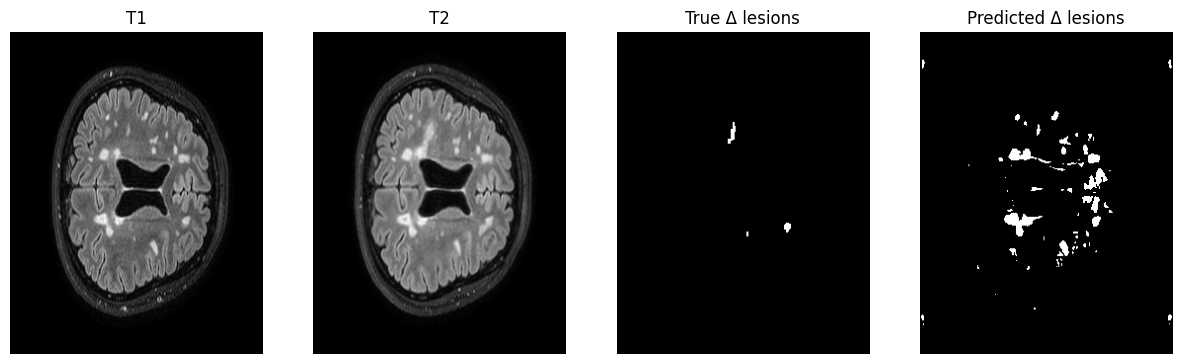

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nifti(path):
    return nib.load(path).get_fdata()

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def show_comparison(t1_slice, t2_slice, seg_slice, pred_slice):
    plt.figure(figsize=(15,5))
    titles = ["T1", "T2", "True Δ lesions", "Predicted Δ lesions"]
    images = [t1_slice, t2_slice, seg_slice, pred_slice]
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --------------------------
# Load files
# --------------------------

T1_PATH = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January/00713519/00713519_20181002.nii.gz"

# Use REGISTERED T2 instead of raw T2!
T2_PATH = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January/00713519/00713519_20190830_to_FLAIR_1.nii.gz"

SEG_PATH = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January/00713519/Segmentation-label.nii.gz"
PRED_PATH = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds/00713519.nii.gz"


t1 = load_nifti(T1_PATH)
t2 = load_nifti(T2_PATH)
seg = load_nifti(SEG_PATH)
pred = load_nifti(PRED_PATH)

print("Shapes:")
print("T1:", t1.shape)
print("T2:", t2.shape)
print("SEG:", seg.shape)
print("PRED:", pred.shape)

# --------------------------
# Choose slice manually
# --------------------------
slice_idx_t1 = 150   # choose any slice < T1 slices
slice_idx_t2 = int(slice_idx_t1 * (t2.shape[2] / t1.shape[2]))   # automatic mapping

print("T1 slice:", slice_idx_t1)
print("T2 slice:", slice_idx_t2)

t1_slice = normalize(t1[:, :, slice_idx_t1])
t2_slice = normalize(t2[:, :, slice_idx_t2])

# segmentation and prediction are aligned with T1
seg_slice = seg[:, :, slice_idx_t1]
pred_slice = pred[:, :, slice_idx_t1]

show_comparison(t1_slice, t2_slice, seg_slice, pred_slice)


Denoising and post processings

Postprocessing complete!


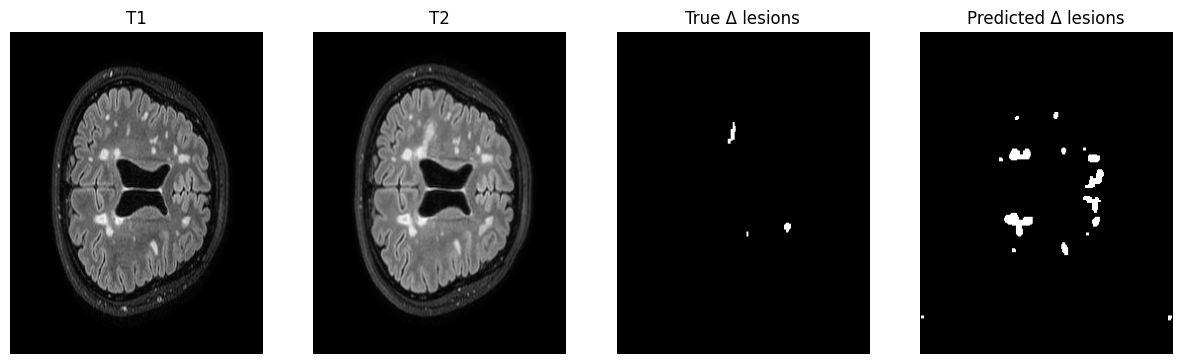

In [ ]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# --------------------
# 1. Binarize prediction
# --------------------
pred_bin = pred > 0.5  # if pred is already 0/1, keep this

# --------------------
# 2. Remove small components (< 30 voxels)
# --------------------
labeled, num = ndi.label(pred_bin)
sizes = ndi.sum(pred_bin, labeled, range(num + 1))

clean_pred = pred_bin.copy()
for component_id, size in enumerate(sizes):
    if size < 30:  # threshold in voxels
        clean_pred[labeled == component_id] = 0

# --------------------
# 3. Morphological smoothing
# --------------------
clean_pred = ndi.binary_opening(clean_pred, structure=np.ones((3,3,3)))
clean_pred = ndi.binary_closing(clean_pred, structure=np.ones((3,3,3)))

# --------------------
# 4. Remove border artifacts
# --------------------
clean_pred[0,:,:] = 0
clean_pred[-1,:,:] = 0
clean_pred[:,0,:] = 0
clean_pred[:,-1,:] = 0
clean_pred[:,:,0] = 0
clean_pred[:,:,-1] = 0

print("Postprocessing complete!")

# --------------------
# Visualize clean prediction instead of raw
# --------------------
clean_pred_slice = clean_pred[:, :, slice_idx_t1]

show_comparison(
    t1_slice,
    t2_slice,
    seg_slice,
    clean_pred_slice
)


now with correct logic

In [ ]:
import os
import shutil

# Base folders
base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"
src = os.path.join(base, "imagesTs")
dst_t1 = os.path.join(base, "T1_only")
dst_t2 = os.path.join(base, "T2_only")

# Create output folders
os.makedirs(dst_t1, exist_ok=True)
os.makedirs(dst_t2, exist_ok=True)

# List all files in imagesTs
files = sorted(os.listdir(src))

for f in files:
    full_path = os.path.join(src, f)

    # Skip non-NIFTI files
    if not f.endswith(".nii.gz"):
        continue

    # Extract case ID (00713519 part)
    case_id = f.split("_")[0]

    # -------------------------
    # HANDLE T1 (channel 0000)
    # -------------------------
    if "_0000.nii.gz" in f:
        dst = os.path.join(dst_t1, f"{case_id}_0000.nii.gz")
        print(f"Copying T1 → {dst}")
        shutil.copy(full_path, dst)

    # -------------------------
    # HANDLE T2 (channel 0001)
    # -------------------------
    if "_0001.nii.gz" in f:
        # nnU-Net requires the modality to always be _0000.nii.gz
        dst = os.path.join(dst_t2, f"{case_id}_0000.nii.gz")
        print(f"Copying T2 (renamed to _0000) → {dst}")
        shutil.copy(full_path, dst)

print("\nDONE! Folders created:")
print(" -", dst_t1)
print(" -", dst_t2)


Copying T1 → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_only/00713519_0000.nii.gz
Copying T2 (renamed to _0000) → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_only/00713519_0000.nii.gz
Copying T1 → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_only/00960975_0000.nii.gz
Copying T2 (renamed to _0000) → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_only/00960975_0000.nii.gz
Copying T1 → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_only/00981157_0000.nii.gz
Copying T2 (renamed to _0000) → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_only/00981157_0000.nii.gz
Copying T1 → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_only/01092669_0000.nii.gz
Copying T2 (renamed to _0000) → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_only/01092669_0000.nii.gz
Copying T1 → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_only/01386182_0000.nii.gz
Copying T2 (renamed to _0000) → /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_only/013861

In [ ]:
import os
import shutil

base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"
src = os.path.join(base, "T1_only")
dst = os.path.join(base, "T1_2ch")

os.makedirs(dst, exist_ok=True)

files = sorted(os.listdir(src))

for f in files:
    if not f.endswith(".nii.gz"):
        continue

    case = f.split("_")[0]

    t1_path = os.path.join(src, f)

    # Create new case folder name
    out0 = os.path.join(dst, f"{case}_0000.nii.gz")  # channel 0
    out1 = os.path.join(dst, f"{case}_0001.nii.gz")  # channel 1 (duplicate)

    print(f"Creating 2-channel T1 for case {case}")

    shutil.copy(t1_path, out0)
    shutil.copy(t1_path, out1)

print("DONE! T1-only 2-channel folder ready:", dst)


Creating 2-channel T1 for case 00713519
Creating 2-channel T1 for case 00960975
Creating 2-channel T1 for case 00981157
Creating 2-channel T1 for case 01092669
Creating 2-channel T1 for case 01386182
Creating 2-channel T1 for case 01406050
Creating 2-channel T1 for case 01563167
Creating 2-channel T1 for case 01581148
Creating 2-channel T1 for case 01668999
Creating 2-channel T1 for case 01722254
Creating 2-channel T1 for case 01888003
DONE! T1-only 2-channel folder ready: /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_2ch


In [ ]:
!nnUNetv2_predict \
 -i /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T1_2ch \
 -o /content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds_T1 \
 -d 501 -c 2d -f 0 \
 -chk checkpoint_best.pth \
 -npp 1 -nps 1




#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 11 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 11 cases that I would like to predict

Predicting 00713519:
perform_everything_on_device: True
100% 1956/1956 [01:21<00:00, 23.94it/s]
sending off prediction to background worker for resampling and export
done with 00713519

Predicting 00960975:
perform_everything_on_device: True
100% 1956/1956 [01:23<00:00, 23.50it/s]
sending off prediction to background worker for resampling and export
done with 00960975

Predicting 00981157:
perform_everything_on_device: True
100%

In [ ]:
import os
import shutil   # <-- you were missing this

base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"
src = os.path.join(base, "T2_only")
dst = os.path.join(base, "T2_2ch")

os.makedirs(dst, exist_ok=True)

files = sorted(os.listdir(src))

for f in files:
    if not f.endswith(".nii.gz"):
        continue

    case = f.split("_")[0]

    t2_path = os.path.join(src, f)

    out0 = os.path.join(dst, f"{case}_0000.nii.gz")
    out1 = os.path.join(dst, f"{case}_0001.nii.gz")

    print(f"Creating 2-channel T2 for case {case}")

    shutil.copy(t2_path, out0)
    shutil.copy(t2_path, out1)

print("DONE! T2-only 2-channel folder ready at:", dst)


Creating 2-channel T2 for case 00713519
Creating 2-channel T2 for case 00960975
Creating 2-channel T2 for case 00981157
Creating 2-channel T2 for case 01092669
Creating 2-channel T2 for case 01386182
Creating 2-channel T2 for case 01406050
Creating 2-channel T2 for case 01563167
Creating 2-channel T2 for case 01581148
Creating 2-channel T2 for case 01668999
Creating 2-channel T2 for case 01722254
Creating 2-channel T2 for case 01888003
DONE! T2-only 2-channel folder ready at: /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_2ch


In [ ]:
!nnUNetv2_predict \
 -i /content/drive/MyDrive/nnUNetZeinab/reviewed_data/T2_2ch \
 -o /content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds_T2 \
 -d 501 -c 2d -f 0 \
 -chk checkpoint_best.pth \
 -npp 1 -nps 1



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 11 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 11 cases that I would like to predict

Predicting 00713519:
perform_everything_on_device: True
100% 1232/1232 [00:49<00:00, 25.03it/s]
sending off prediction to background worker for resampling and export
done with 00713519

Predicting 00960975:
perform_everything_on_device: True
100% 1956/1956 [01:20<00:00, 24.18it/s]
sending off prediction to background worker for resampling and export
done with 00960975

Predicting 00981157:
perform_everything_on_device: True
100%

Normalized t1 t2

In [ ]:
import nibabel as nib
import numpy as np
import os
import shutil

def zscore(img):
    return (img - img.mean()) / (img.std() + 1e-8)

base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"
src = os.path.join(base, "imagesTs")

dst_T1 = os.path.join(base, "T1_2ch_norm")
dst_T2 = os.path.join(base, "T2_2ch_norm")
os.makedirs(dst_T1, exist_ok=True)
os.makedirs(dst_T2, exist_ok=True)

files = sorted(os.listdir(src))

for f in files:
    if not f.endswith("0000.nii.gz"):
        continue

    case = f.split("_")[0]

    t1_path = os.path.join(src, f"{case}_0000.nii.gz")
    t2_path = os.path.join(src, f"{case}_0001.nii.gz")

    t1 = nib.load(t1_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()

    t1_norm = zscore(t1)
    t2_norm = zscore(t2)

    nib.save(nib.Nifti1Image(t1_norm, None), os.path.join(dst_T1, f"{case}_0000.nii.gz"))
    nib.save(nib.Nifti1Image(t1_norm, None), os.path.join(dst_T1, f"{case}_0001.nii.gz"))

    nib.save(nib.Nifti1Image(t2_norm, None), os.path.join(dst_T2, f"{case}_0000.nii.gz"))
    nib.save(nib.Nifti1Image(t2_norm, None), os.path.join(dst_T2, f"{case}_0001.nii.gz"))

print("Done generating normalized T1/T2 sets.")


FileNotFoundError: No such file or no access: '/content/drive/MyDrive/nnUNetZeinab/reviewed_data/imagesTs/01406050_0000.nii.gz'

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

# ====== CONFIG ======
nnunet_base = "/content/drive/MyDrive/nnUNetZeinab/reviewed_data"
reviewed_base = "/content/drive/MyDrive/Reviewed 14 cases- Dec_January"

imagesTs_dir = os.path.join(nnunet_base, "imagesTs")
preds_T1_dir = os.path.join(nnunet_base, "preds_T1")
preds_T2_dir = os.path.join(nnunet_base, "preds_T2")

out_delta_dir = os.path.join(nnunet_base, "delta_preds")       # Δ-prediction masks
out_fig_dir = os.path.join(nnunet_base, "delta_figures")       # PNG summaries
os.makedirs(out_delta_dir, exist_ok=True)
os.makedirs(out_fig_dir, exist_ok=True)

# ====== UTILS ======

def load_nii(path):
    return nib.load(path)

def get_data(path):
    return load_nii(path).get_fdata()

def binarize(x):
    return (x > 0).astype(np.uint8)

def clean_mask(mask, min_voxels=30):
    """Remove tiny components + light morph smoothing."""
    mask = mask.astype(bool)
    labeled, num = ndi.label(mask)
    sizes = ndi.sum(mask, labeled, range(num + 1))
    clean = np.zeros_like(mask, dtype=bool)
    for comp_id, size in enumerate(sizes):
        if size >= min_voxels:
            clean[labeled == comp_id] = True
    # small opening/closing to smooth
    clean = ndi.binary_opening(clean, structure=np.ones((3,3,3)))
    clean = ndi.binary_closing(clean, structure=np.ones((3,3,3)))
    return clean.astype(np.uint8)

def dice_score(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    if denom == 0:
        return 1.0  # both empty
    return 2 * inter / denom

def sensitivity(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    tp = np.logical_and(pred, gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    if tp + fn == 0:
        return 1.0
    return tp / (tp + fn)

def precision(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, ~gt).sum()
    if tp + fp == 0:
        return 1.0
    return tp / (tp + fp)

def find_lesion_slice(mask):
    """Return an index of a slice that has lesions (or center if none)."""
    per_slice = mask.sum(axis=(0,1))
    lesion_slices = np.where(per_slice > 0)[0]
    if len(lesion_slices) == 0:
        return mask.shape[2] // 2
    return lesion_slices[len(lesion_slices)//2]

# ====== COLLECT CASE IDS FROM imagesTs ======

all_files = sorted(os.listdir(imagesTs_dir))
case_ids = sorted({f.split("_")[0] for f in all_files if f.endswith(".nii.gz")})
print("Found case IDs:", case_ids)

results = []

# ====== MAIN LOOP OVER ALL CASES ======
for case in case_ids:
    print(f"\n=== Case {case} ===")

    # Paths
    t1_path = os.path.join(imagesTs_dir, f"{case}_0000.nii.gz")
    t2_path = os.path.join(imagesTs_dir, f"{case}_0001.nii.gz")
    pred_t1_path = os.path.join(preds_T1_dir, f"{case}.nii.gz")
    pred_t2_path = os.path.join(preds_T2_dir, f"{case}.nii.gz")
    gt_path = os.path.join(reviewed_base, case, "Segmentation-label.nii.gz")

    # Check existence
    missing = []
    for p, name in [(t1_path, "T1"), (t2_path, "T2"),
                    (pred_t1_path, "pred_T1"), (pred_t2_path, "pred_T2"),
                    (gt_path, "GT")]:
        if not os.path.exists(p):
            missing.append(name)
    if missing:
        print(f"  Skipping case {case} (missing: {missing})")
        continue

    # ---- Load volumes ----
    t1_img = load_nii(t1_path)
    t1 = t1_img.get_fdata()
    t2 = get_data(t2_path)
    pred_t1 = binarize(get_data(pred_t1_path))
    pred_t2 = binarize(get_data(pred_t2_path))
    gt = binarize(get_data(gt_path))

    # ---- Clean predictions (denoise) ----
    pred_t1_clean = clean_mask(pred_t1, min_voxels=30)
    pred_t2_clean = clean_mask(pred_t2, min_voxels=30)

    # ---- Δ prediction: lesions present at T2 but not T1 ----
    delta_pred = np.logical_and(pred_t2_clean == 1, pred_t1_clean == 0).astype(np.uint8)

    # Save Δ-pred as NIfTI in same space as T1
    delta_img = nib.Nifti1Image(delta_pred.astype(np.uint8), t1_img.affine, t1_img.header)
    delta_out_path = os.path.join(out_delta_dir, f"{case}_delta_pred.nii.gz")
    nib.save(delta_img, delta_out_path)

    # ---- Metrics vs GT (true Δ) ----
    d = dice_score(delta_pred, gt)
    sens = sensitivity(delta_pred, gt)
    prec = precision(delta_pred, gt)
    print(f"  Dice: {d:.3f}, Sens: {sens:.3f}, Prec: {prec:.3f}")

    results.append({
        "case": case,
        "dice": d,
        "sensitivity": sens,
        "precision": prec,
    })

    # ---- Figure: T1, T2, GT Δ, predicted Δ ----
    slice_idx = find_lesion_slice(gt)
    t1_slice = t1[:,:,slice_idx]
    t2_slice = t2[:,:,slice_idx]
    gt_slice = gt[:,:,slice_idx]
    delta_slice = delta_pred[:,:,slice_idx]

    plt.figure(figsize=(22,6))
    plt.suptitle(f"Case {case} – slice {slice_idx}", fontsize=14)

    plt.subplot(1,4,1)
    plt.title("T1")
    plt.imshow(t1_slice, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("T2")
    plt.imshow(t2_slice, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("True Δ lesions")
    plt.imshow(gt_slice, cmap="gray")
    plt.imshow(gt_slice, cmap="Reds", alpha=0.8)
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Predicted Δ lesions\n(pred_T2_clean − pred_T1_clean)")
    plt.imshow(t2_slice, cmap="gray")
    plt.imshow(delta_slice, cmap="Blues", alpha=0.8)
    plt.axis("off")

    fig_path = os.path.join(out_fig_dir, f"{case}_delta_overview.png")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()

print("\n==== SUMMARY ====")
for r in results:
    print(f"{r['case']}: Dice={r['dice']:.3f}, Sens={r['sensitivity']:.3f}, Prec={r['precision']:.3f}")


Found case IDs: ['00713519', '00960975', '00981157', '01092669', '01386182', '01406050', '01563167', '01581148', '01668999', '01722254', '01888003']

=== Case 00713519 ===
  Dice: 0.012, Sens: 0.508, Prec: 0.006

=== Case 00960975 ===
  Dice: 0.015, Sens: 0.653, Prec: 0.008

=== Case 00981157 ===
  Dice: 0.050, Sens: 0.870, Prec: 0.026

=== Case 01092669 ===
  Dice: 0.008, Sens: 0.621, Prec: 0.004

=== Case 01386182 ===
  Dice: 0.066, Sens: 0.836, Prec: 0.034

=== Case 01406050 ===
  Skipping case 01406050 (missing: ['T1', 'T2'])

=== Case 01563167 ===
  Dice: 0.014, Sens: 0.636, Prec: 0.007

=== Case 01581148 ===
  Skipping case 01581148 (missing: ['T1', 'T2', 'GT'])

=== Case 01668999 ===
  Dice: 0.016, Sens: 0.509, Prec: 0.008

=== Case 01722254 ===
  Dice: 0.004, Sens: 0.563, Prec: 0.002

=== Case 01888003 ===
  Dice: 0.004, Sens: 0.766, Prec: 0.002

==== SUMMARY ====
00713519: Dice=0.012, Sens=0.508, Prec=0.006
00960975: Dice=0.015, Sens=0.653, Prec=0.008
00981157: Dice=0.050, Sen

FINAL CORRECT PLOTTING

Using slice: 153


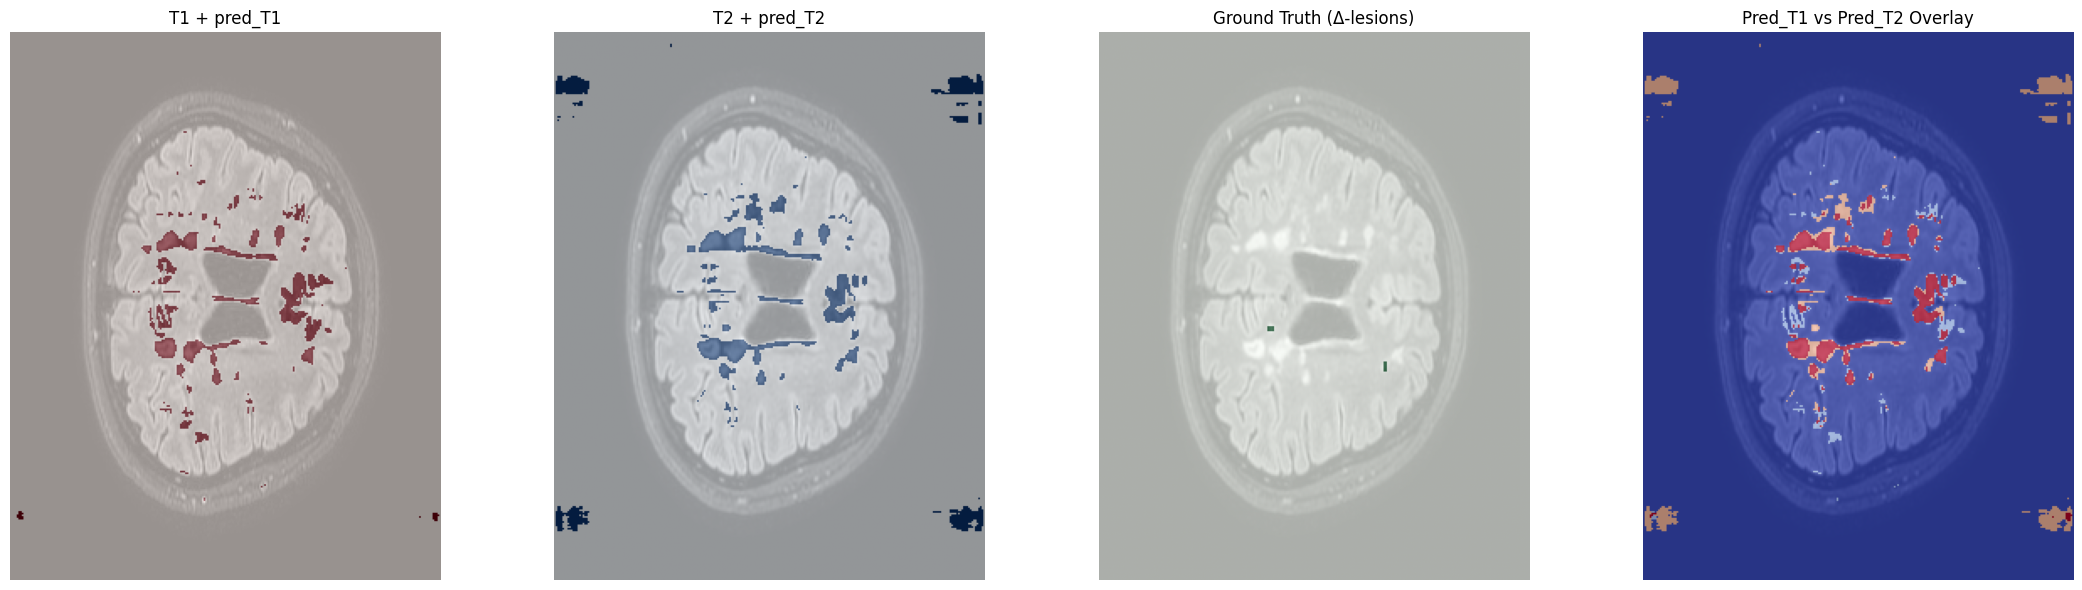

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
case = "00713519"

# nnU-Net prediction folders
pred_T1_path = f"/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds_T1/{case}.nii.gz"
pred_T2_path = f"/content/drive/MyDrive/nnUNetZeinab/reviewed_data/preds_T2/{case}.nii.gz"

# Your original images and GT, fix paths according to image
T1_path = f"/content/drive/MyDrive/Reviewed 14 cases- Dec_January/{case}/{case}_20181002.nii.gz"
T2_path = f"/content/drive/MyDrive/Reviewed 14 cases- Dec_January/{case}/{case}_20190830_to_FLAIR_1.nii.gz"
GT_path = f"/content/drive/MyDrive/Reviewed 14 cases- Dec_January/{case}/Segmentation-label.nii.gz"

# -------------------------
# LOAD DATA
# -------------------------
T1 = nib.load(T1_path).get_fdata()
T2 = nib.load(T2_path).get_fdata()
pred_T1 = (nib.load(pred_T1_path).get_fdata() > 0).astype(np.uint8)
pred_T2 = (nib.load(pred_T2_path).get_fdata() > 0).astype(np.uint8)
GT = (nib.load(GT_path).get_fdata() > 0).astype(np.uint8)

# -------------------------
# FIND SLICE WITH GT LESIONS
# -------------------------
lesion_slices = np.where(GT.sum(axis=(0,1)) > 0)[0]
if len(lesion_slices) == 0:
    slice_idx = T1.shape[2] // 2
else:
    slice_idx = lesion_slices[len(lesion_slices)//2]

print("Using slice:", slice_idx)

# extract slices
t1s = T1[:,:,slice_idx]
t2s = T2[:,:,slice_idx]
p1s = pred_T1[:,:,slice_idx]
p2s = pred_T2[:,:,slice_idx]
gts = GT[:,:,slice_idx]

# -------------------------
# VISUALIZE
# -------------------------
plt.figure(figsize=(22,6))

plt.subplot(1,4,1)
plt.title("T1 + pred_T1")
plt.imshow(t1s, cmap="gray")
plt.imshow(p1s, cmap="Reds", alpha=0.6)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("T2 + pred_T2")
plt.imshow(t2s, cmap="gray")
plt.imshow(p2s, cmap="Blues", alpha=0.6)
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Ground Truth (Δ-lesions)")
plt.imshow(t2s, cmap="gray")
plt.imshow(gts, cmap="Greens", alpha=0.7)
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Pred_T1 vs Pred_T2 Overlay")
overlay = p1s*1 + p2s*2
# 1 = red (T1 pred)
# 2 = blue (T2 pred)
plt.imshow(t2s, cmap="gray")
plt.imshow(overlay, cmap="coolwarm", alpha=0.7)
plt.axis("off")

plt.tight_layout()
plt.show()
